<a href="https://colab.research.google.com/github/MelihKlc/Deep-Learning/blob/main/Transfer_Learning_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will get our helper function script

# Our goal is to beat the original Food101 paper's results with 10% of data.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-13 16:19:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-13 16:19:01 (82.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import from helper function what we need

from helper_functions import unzip_data ,  plot_loss_curves , walk_through_dir , create_tensorboard_callback , compare_historys

In [3]:
# Download 10 percent of Food Vision 101
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

# Set up train and test directory

train_dir = "/content/101_food_classes_10_percent/train"
test_dir = "/content/101_food_classes_10_percent/test"

# Set up training and test set datas

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir ,
                                                                 batch_size = 32 ,
                                                                 image_size = (224,224) ,
                                                                 label_mode = "categorical"
                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                 batch_size = 32 ,
                                                                 image_size = (224,224) ,
                                                                 label_mode = "categorical" ,
                                                                 shuffle = False  # Dont shuffle test data for prediction analysis
                                                                 )

--2023-08-13 16:19:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   136MB/s    in 14s     

2023-08-13 16:19:25 (114 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Here are the steps we are going to take:
* Create a model check point tensorboard.
* Create a data augmentation layer to build data augmentation right into the model.
* Build a headless (no top layers) functional EfficientNetB0 backboned-model ( we will create our own output layer)
* Compile our model
* Feature extract for full 5 passes ( 5 epochs on the train dataset and validation on %15 of the test data , to save epoch time)
* Fine-tuning continue with the end of the feature extract model's epochs

In [4]:
# Set the checkpoint path
checkpoint_path = "101_food_classes_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path ,
    monitor = "val_accuracy" ,
    save_weights_only = True ,
    save_best_only = True
 )

In [5]:
# Data augmentation layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal") ,
        preprocessing.RandomZoom(0.2) ,
        preprocessing.RandomHeight(0.2) ,
        preprocessing.RandomWidth(0.2),
        preprocessing.RandomRotation(0.2)
    ] , name = "data_augmentation"

)

In [6]:
# Building feature extraction model with keras API

base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "input_layer")

x = data_augmentation(inputs)

x = base_model(x , training = False) # Put the base model in inference mode so weights which need to stay frozen , stay frozen

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(101 , activation = "softmax" , name = "output_layer")(x)  # 101 yerine len(train_data.class_names) yazabiliriz. Class sayısını bilmedigimiz datalarda böyle yapılabilir.

model_1 = tf.keras.Model(inputs , outputs)

# Compile a model

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

# Fit the model
initial_epochs = 5

history_1 = model_1.fit(train_data ,
                        epochs = initial_epochs ,
                        steps_per_epoch = len(train_data) ,
                        validation_data = test_data ,
                        validation_steps = int(0.15 * len(test_data)) ,
                        callbacks = [checkpoint_callback]
                        )


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/5
237/237 [==============================] - 145s 541ms/step - loss: 3.3768 - accuracy: 0.2795 - val_loss: 2.4303 - val_accuracy: 0.4817
Epoch 2/5
237/237 [==============================] - 94s 378ms/step - loss: 2.2302 - accuracy: 0.4904 - val_loss: 2.0212 - val_accuracy: 0.5162
Epoch 3/5
237/237 [==============================] - 72s 303ms/step - loss: 1.8396 - accuracy: 0.5632 - val_loss: 1.8595 - val_accuracy: 0.5312
Epoch 4/5
237/237 [==============================] - 62s 260ms/step - loss: 1.6283 - accuracy: 0.6053 - val_loss: 1.7860 - val_accuracy: 0.5371
Epoch 5/5
237/237 [==============================] - 57s 241ms/step - loss: 1.4610 - accuracy: 0.6434 - val_loss: 1.7135 - val_accuracy: 0.5471


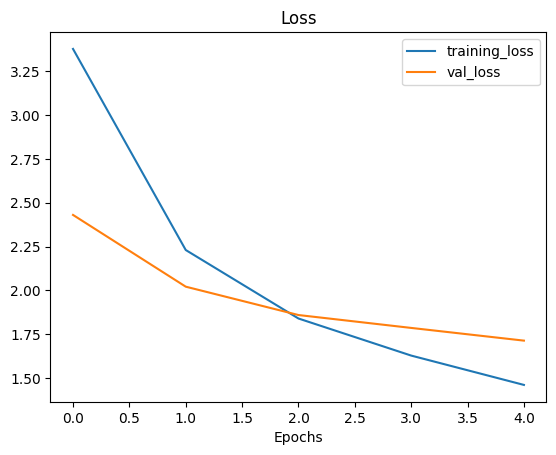

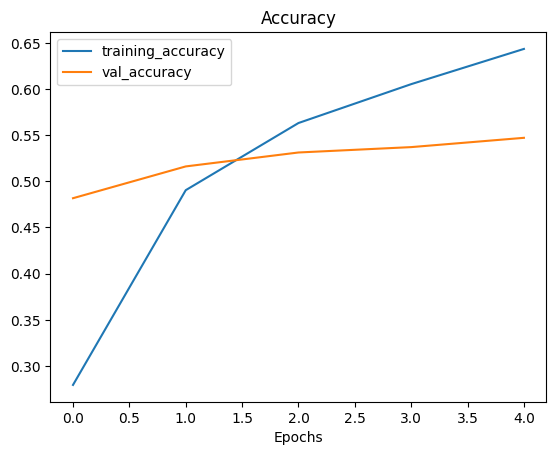

In [7]:
plot_loss_curves(history_1)

# What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

In [8]:
model_1_evaluate = model_1.evaluate(test_data)  # 100 percent of the test data

790/790 [==============================] - 66s 84ms/step - loss: 1.5777 - accuracy: 0.5821


# Feature extraction modelimizi tamamladık ve train ettik. %57 accuracy aldık. Şimdi fine-tuning yapıcaz.

In [9]:
# Lets unfreeze all of the layers and then we will freeze all of the layers except last 10.

base_model.trainable = True

for layer in base_model.layers[ : -5]:
  layer.trainable = False

# Recompile it for fine-tuning

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) ,
                metrics = ["accuracy"]
                )




In [10]:
# Fit the model
fine_tune_epochs = initial_epochs + 5  #fine tune epochs aslında bizim total number of epochs umuz oluyor. Yani eğer feature extraction yaparken 5 epoch kullandıysak burda 10 epoch belirlediğimizde fine tune için 5 epoch kullanıcaz ( 5 (feature extraction) + 5 (fine-tuning) )

history_2 = model_1.fit(train_data ,
                     epochs = fine_tune_epochs ,
                     steps_per_epoch = len(train_data) ,
                     initial_epoch = history_1.epoch[-1] ,
                     validation_data = test_data ,
                     validation_steps = int( 0.15 * len(test_data)) ,
                     callbacks = [checkpoint_callback]
                     )

Epoch 5/10
237/237 [==============================] - 72s 257ms/step - loss: 1.2427 - accuracy: 0.6774 - val_loss: 1.6705 - val_accuracy: 0.5540
Epoch 6/10
237/237 [==============================] - 58s 235ms/step - loss: 1.1366 - accuracy: 0.6937 - val_loss: 1.6502 - val_accuracy: 0.5567
Epoch 7/10
237/237 [==============================] - 50s 207ms/step - loss: 1.0477 - accuracy: 0.7242 - val_loss: 1.6798 - val_accuracy: 0.5487
Epoch 8/10
237/237 [==============================] - 62s 258ms/step - loss: 0.9970 - accuracy: 0.7349 - val_loss: 1.6186 - val_accuracy: 0.5638
Epoch 9/10
237/237 [==============================] - 61s 258ms/step - loss: 0.9231 - accuracy: 0.7500 - val_loss: 1.6930 - val_accuracy: 0.5485
Epoch 10/10
237/237 [==============================] - 58s 246ms/step - loss: 0.8689 - accuracy: 0.7616 - val_loss: 1.6513 - val_accuracy: 0.5638


In [11]:
# Evaluating fine-tuning model
fine_tune_eva = model_1.evaluate(test_data)

790/790 [==============================] - 88s 111ms/step - loss: 1.4899 - accuracy: 0.6048


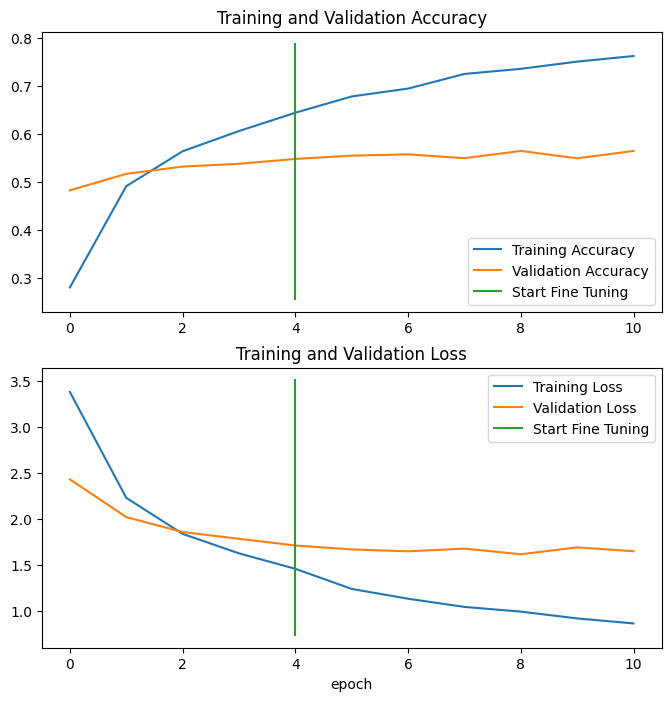

In [12]:
# Compare the results
compare_historys(original_history = history_1 ,
                 new_history = history_2 ,
                 initial_epochs = 5
                 )

# Saving and loading our model

To use our model for external application , we will need to save it and export it somewhere

In [13]:
# # Save model to drive so it can be used later
#model_1.save("drive/My Drive/101_food_class_10_percent_saved_big_dog_model")

# Evaluating the performance of our model across all different classes

Lets make some predictions , visualize them and then find out which predictions were the most wrong

In [14]:
# Download pre-trained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-08-13 16:39:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   182MB/s    in 0.2s    

2023-08-13 16:39:22 (182 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [15]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [16]:
 # Load the saved model
 model_pre = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [17]:
# Evaluate loaded model
eva_model_pre = model_pre.evaluate(test_data)

790/790 [==============================] - 77s 95ms/step - loss: 1.8027 - accuracy: 0.6078


In [18]:
# Making predictions with our model

pred_probs = model_pre.predict(test_data , verbose = 1)  # Set verbosity 1 to see how long is left





790/790 [==============================] - 89s 110ms/step


In [19]:
len(test_data)

790

In [20]:
# How many predictions are there?
len(pred_probs)

25250

In [21]:
# What is the shape of our prediction. Burda outputta softmax var. Softmaxin özelliğini hatırlarsak her classa bir probability veriyor. Yani burda 1 image için 101 classın hepsine probability vercek. Meslea input olarak donut image girdik. Donut image probability 0.7 çıkacak baklava 0.0012 falan çıkacak. Mantık bu.
pred_probs.shape

(25250, 101)

In [22]:
# How first 10 predictions look like?
pred_probs[ : 10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [23]:
# First pred. As i sad , it has 101 elements because of 101 class we have. Sum of all values inside the 1 image prediction is almost 1 because we have probabilities
pred_probs[0] , len(pred_probs[0]) , sum(pred_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [24]:
# We get one prediction probabilites per class (in our case there is 101 prediction probabilities )

print(f"Number of predictions probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {pred_probs[0]} ")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of predictions probabilities for sample 0: 101
What prediction probability sample 0 looks like: 
 [5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 

In [25]:
# Get the pred classes of each layer
pred_classes = pred_probs.argmax(axis = 1)

# How do they look?
pred_classes[ : 10]  # First image 52. class olarak predict edilmiş bizim modelimize. Second image 0. class olarak predict edilmiş.

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [26]:
# How many pred classes do we have ?
len(pred_classes)

25250

# Now we have got a predictions array of all of our model's predictions , to evaluate them , we need to compare them to the original test dataset labels

In [27]:
# To get our test labels , we need to unravel our test_data BatchDataset

y_labels = []  # Original labels

for images , labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())  # Bu satır, her bir görüntüye karşılık gelen etiketin en büyük değere sahip elemanının indeksini y_labels listesine ekler. Burada, labels etiketlerini Numpy dizisine dönüştürüp .argmax() işlevini kullanarak en yüksek değere sahip sınıfın indeksini buluyoruz.
  # Bizim imagelarımız one hot encoded edilmiş şekilde geliyor. yani [0 , 0 , 0 , 0 , ....... , 1 , 0 , 0 , ...... 0 , 0 , 0] şeklinde. Bu yüzden argmax kullandıgımızda sadece bir adet 1 var bu da classı belirtiyor.

y_labels[ : 10]   # En başta test_labelda shuffle false atamamızın sebebi burda original labellar ile predicted labelları compare ederken aynı sırada olmasını istememiz.

# Burda first 10 in 0 0 0 0 0 çıkmasının sebebi biz shuffle bozmadık bu yüzden ilk 10 fotoğraf hep class 0 dan geliyor ve bu yüzden o imageların label a hep 0. Class 0 daki image sayısı bittiğinde 1 1 1 1 1 1 gelcek artık hep çünkü class 1 e geçiyoruz bu 101 class tamamlanana kadar böyle devam ediyor.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
# How many y_labels are there?
len(y_labels)

25250

In [29]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

# Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [30]:
# Lets try sklearn accuracy function and see what it comes up with it
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels ,
                                  y_pred = pred_classes ,
                                  )
sklearn_accuracy


0.6077623762376237

# Lets get visualize : Confusion Matrix

In [31]:
from helper_functions import make_confusion_matrix

In [32]:
# Get a list of class names

class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [33]:
# Direkt helper function scriptindekini kullanamıyoruz çok fazla class oldugu icin. X labellar karışıyor. X label isimlerini vertically yazdırıcaz.
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed : x labels vertically written
  plt.xticks(rotation = 70 , fontsize = text_size)
  plt.yticks(fontsize = text_size)



  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [34]:
make_confusion_matrix(y_true = y_labels ,
                      y_pred = pred_classes ,
                      classes = class_names ,
                      text_size = 20 ,
                      savefig = True ,
                      figsize = (100 , 100)
                      )

# Keep the evaluation train going , time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision , F1 , Recall) called classification_report.

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels ,
                            y_pred = pred_classes
                            ))

# Bu en baştaki column class numberlarını belirtiyor. Diğerleri için de 1 e ne kadar yakınsa o kadar iyi bizim için. Higher value is better.
# F1 precision ve recall ın birleşmiş hali.

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

# The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, They are quite hard to understand.

So lets create a visualization to get better understanding.

In [36]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels , pred_classes , output_dict = True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [37]:
classification_report_dict["99"]["f1-score"]  # Aşağıdaki for loopunun içinde bunu yapıyoruz.

0.35356200527704484

# Lets plot all of our classes F1-scores

In [38]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k , v in classification_report_dict.items():
  if k == "accuracy": # Stop once we get the accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores



{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [39]:
# Turn f1-scores into dataframe for visualization

import pandas as pd

f1_scores = pd.DataFrame( {"class_names" : list(class_f1_scores.keys()) ,
                           "f1-score" : list(class_f1_scores.values())}).sort_values("f1-score" , ascending = False)  # Dict kullandıgımız icin class namesler key oluyor bu yüzden .key olarak çağırıyoruz.
                           # Aynı şekilde f1 scoreları da values olarak atanıyor dict içinde bu yüzden .values
                           # Azalan şekilde sıralamak için sort_values kullanıyoruz.
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

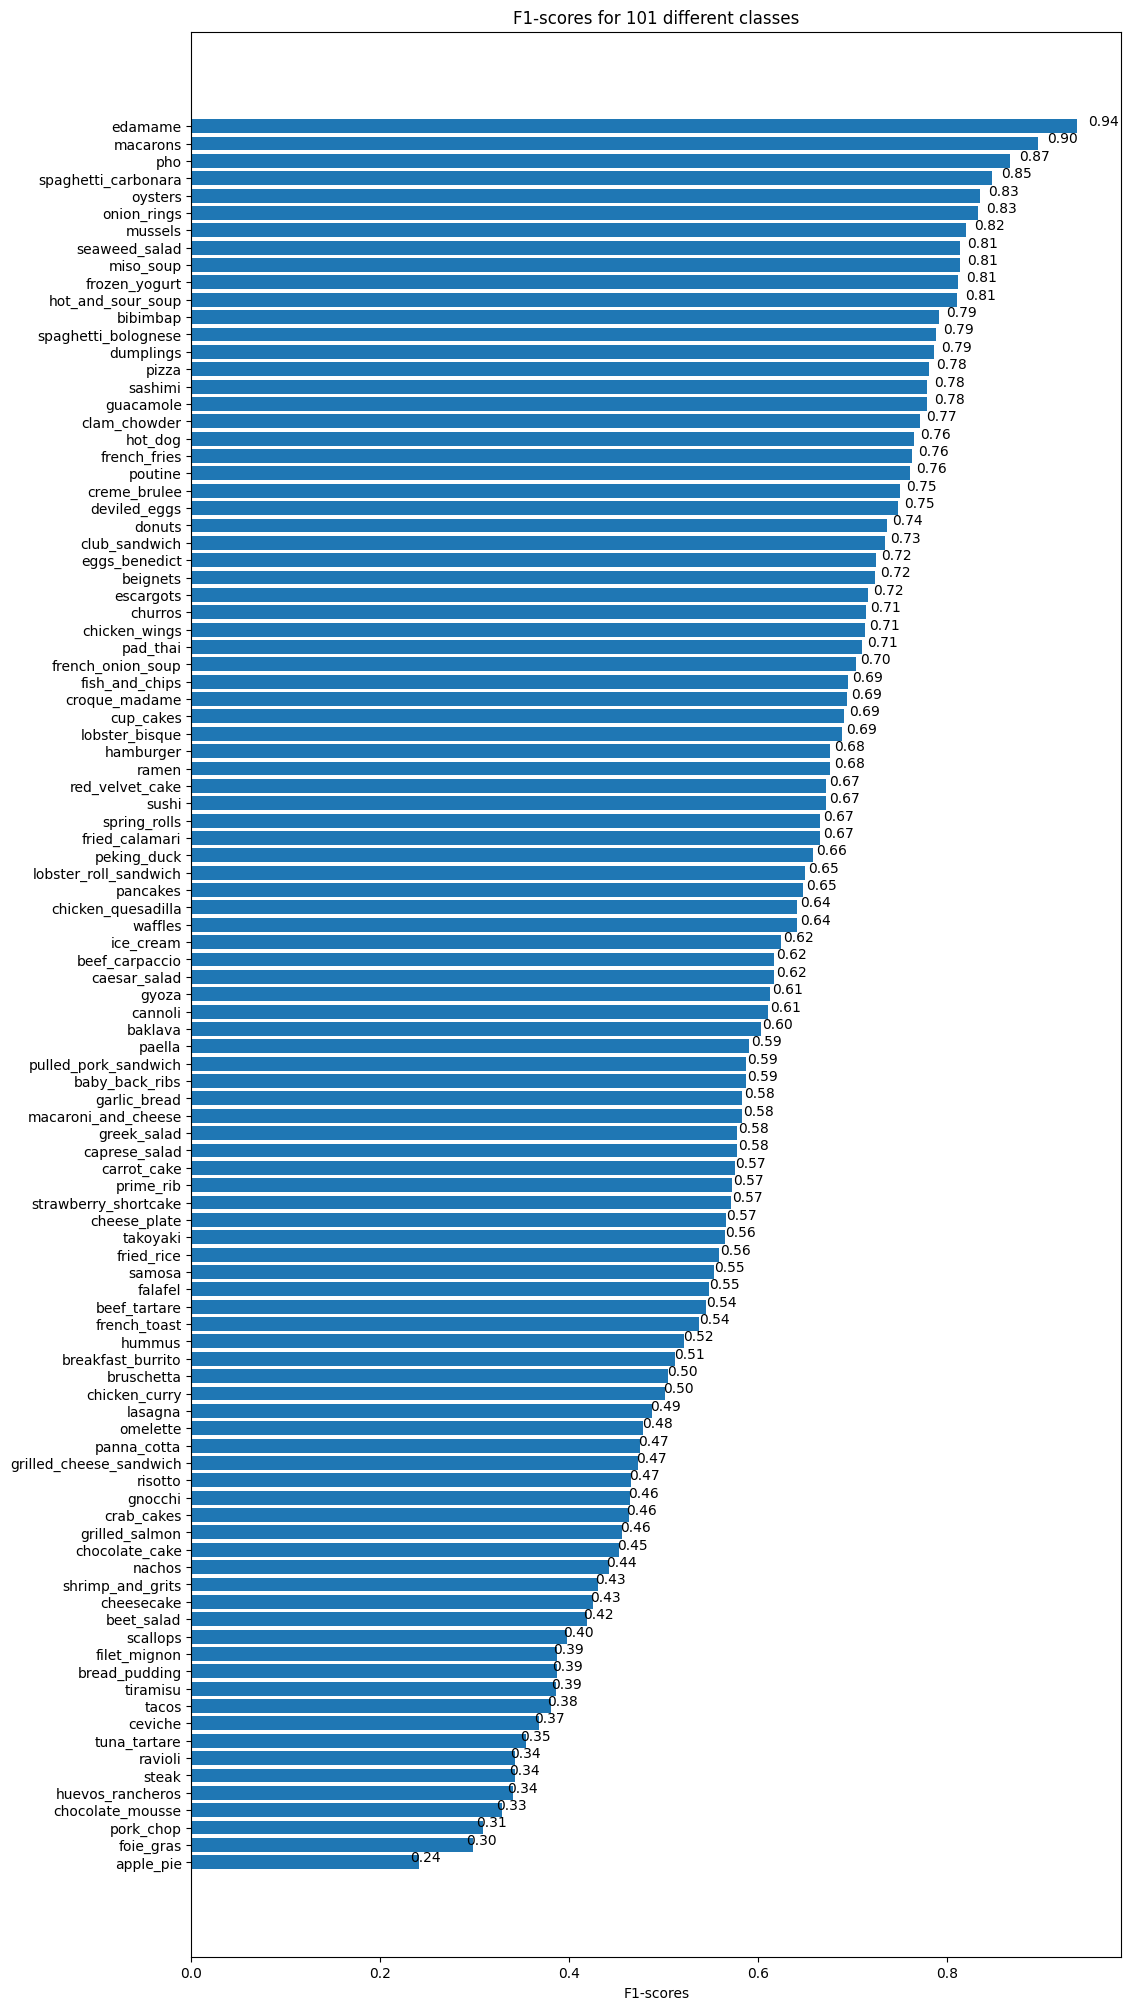

In [40]:
# Visualize it with graph
# Yatay bir çubuk grafik (barh plot)

import matplotlib.pyplot as plt

fig , ax = plt.subplots(figsize = (12 , 25))  # Bu satır, bir altlık (subplot) ve figür nesnesi oluşturur. fig genel figürü temsil ederken, ax altlığı temsil eder. figsize parametresi, oluşturulan figürün genişliğini ve yüksekliğini belirler.
scores = ax.barh(range(len(f1_scores)) , f1_scores["f1-score"].values) # Get f1-score values
ax.set_yticks(range(len(f1_scores)))  # Yatay eksende hangi sınıfların etiketlerinin oluşturulacağını belirlemek için yatay eksendeki tick (işaret) konumlarını ayarlar. Burada, her sınıf için bir işaret belirlenir.
ax.set_yticklabels(f1_scores["class_names"])  # Bu komutla, yatay eksendeki işaretlerin hangi etiketlerle eşleşeceğini belirleriz. Burada varsayılan olarak f1-scores veri çerçevesindeki "class_names" sütunundaki değerler kullanılır.
ax.set_xlabel("F1-scores")
ax.set_title("F1-scores for 101 different classes")
ax.invert_yaxis();  # Reverse the order of our plot.

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)




# Try to visualize some of the most poorly predicted classes (e.g. apple pie , pork chip). Do you notice any trends among them? Why might our model be having trouble with them?

# Visualizing predictions on the test set

Now , this is a real test , How does our model go on food images not even in our test dataset (images of our own).

To visualize our model's predictions on our own images , we will need a function to load and preprocess images, spesifically it will need to :

1. Read in a target image filepath using tf.io.read_file()
2. Turn the image into Tensor using tf.io.decode_image()
3. Resize the image tensor to be the same size as the images our model has trained on using tf.images.resize()
4. Scale the image to get all the pixel values of image between 0 and 1 (if necessary)





In [41]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_image(img , channels = 3)  # Helper function scriptte decode_jpeg vardı sadece jpeg formatında giriline image ları modele sokabiliyordu. Burda direkt image diyoruz tüm formattaki resimleri modele input alabilmemiz için. Channel = 3 diyoruz çünkü PNG formatında dosya yüklenirse PNG formatının color_channel ı 4 oluyor. Bizim modelimiz 3 color channelda çalışıyor RGB. Yani PNG yüklenirse 4 channeldan 3 channela çevirecek image ı
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Now we have got the function to load and prepare target images , lets write some code to visualize images , their target labels , and our model's predictions

We will write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on the loaded images.
3. Plot the original images along with the model's predictions , prediction probability and truth label.

(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 2s 2s/step
(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step


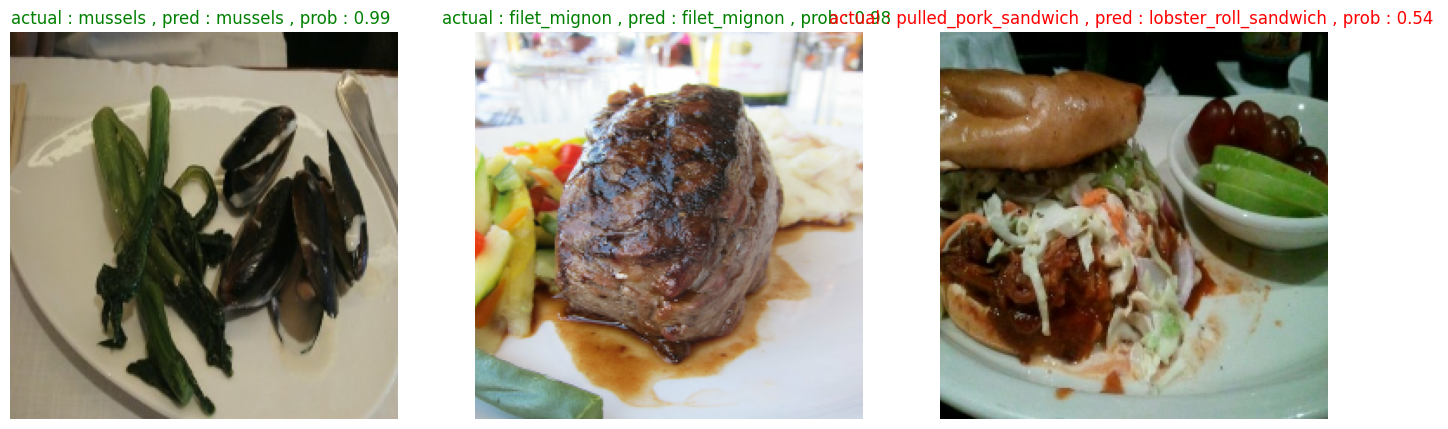

In [42]:
# Make preds on a series of random images

import os
import random

plt.figure(figsize = (17 , 10))

for i in range(3):
  # Choose random images from random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the images and make predictions
  img = load_and_prep_image(filename = filepath , scale = False) # Because we are using EfficientNetB0 and it is already scaled
  print(img.shape)
  img_expanded = tf.expand_dims(img , axis = 0)  # Train datamızı batch size varken train ettiğimiz için aynı shape istiyor şu an. O yüzden 0. axise shape ekliyoruz.
  print(img_expanded.shape)
  pred_prob = model_pre.predict(img_expanded)   # Get prediction probabilities array.
  pred_class = class_names[pred_prob.argmax()]  # Get the highest prediction probability index and match it the class_names list

  # Plot images
  plt.subplot(1 , 3 , i+1)  # i 0 dan başlıyor bize 1 2 3 lazım o yüzden böyle yazdık
  plt.imshow(img/255.)  # 255 e bölmediğimizde 0 la 255 arasında değerleri oluyor pixellerin bu yüzden burda bunu yapmamız lazım
  if class_name == pred_class:  # if predicted class matches truth class , the text will be green , if not , the text will be red
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual : {class_name} , pred : {pred_class} , prob : {pred_prob.max():.2f} " , c = title_color)
  plt.axis(False);







# Finding the most wrong predictions

1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a pandas dataframe of the image filepaths , ground truth labels , predicted classes(from our model) , max prediction probabilities , prediction class names , ground truth class names.
3. Use our dataframe to find all the wrong predictions (when the ground truth label doesnt match the predictions).
4. Sort the dataframe based on wrong predictions (have the highest prediction probability predictions at the top  ).
5. Visualize the images with the highest prediction probabilites but have the wrong predictions.

In [44]:
# Get all of the image file paths in the test dataset

filepaths = []

# list_files içindeki * ların anlamı all demek yani hepsini alıyoruz.
# First star means that all of the classes in test dataset and second star means that all of the jpeg files in directory.

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg" , shuffle = False):
  filepaths.append(filepath.numpy())

filepaths[ : 10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [45]:
# Create a DataFrame of different parameters for each of our test images
import pandas as pd

pred_df = pd.DataFrame({"image_path" : filepaths,
                        "ground_truth_labels" : y_labels ,
                        "y_pred" : pred_classes ,
                        "pred_conf": pred_probs.max(axis = 1) , # Get the maximum probability values.
                        "y_true_classname": [class_names[i] for i in y_labels] ,
                        "y_pred_classname": [class_names[i] for i in pred_classes]
                        })
pred_df


image_path  ground_truth_labels  \
0      b'/content/101_food_classes_10_percent/test/ap...                    0   
1      b'/content/101_food_classes_10_percent/test/ap...                    0   
2      b'/content/101_food_classes_10_percent/test/ap...                    0   
3      b'/content/101_food_classes_10_percent/test/ap...                    0   
4      b'/content/101_food_classes_10_percent/test/ap...                    0   
...                                                  ...                  ...   
25245  b'/content/101_food_classes_10_percent/test/wa...                  100   
25246  b'/content/101_food_classes_10_percent/test/wa...                  100   
25247  b'/content/101_food_classes_10_percent/test/wa...                  100   
25248  b'/content/101_food_classes_10_percent/test/wa...                  100   
25249  b'/content/101_food_classes_10_percent/test/wa...                  100   

       y_pred  pred_conf y_true_classname      y_pred_classname  
0          52   0.847419        apple_pie                 gyoza  
1           0   0.964017        apple_pie             apple_pie  
2           0   0.959259        apple_pie             apple_pie  
3          80   0.658606        apple_pie  pulled_pork_sandwich  
4          79   0.367900        apple_pie             prime_rib  
...       ...        ...              ...                   ...  
25245     100   0.972823          waffles               waffles  
25246      16   0.878028          waffles          cheese_plate  
25247     100   0.537899          waffles               waffles  
25248      94   0.501950          waffles  strawberry_shortcake  
25249     100   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [47]:
# Find out which predictions are wrong in our DataFrame

pred_df["pred_correct"] = pred_df["ground_truth_labels"] == pred_df["y_pred"]  # DataFrame imize yeni bir column ekledik pred_correct adında. ground_truth_label ile y_pred aynıysa bu yeni column True döndürecek aynı değilse False döndürecek. Yani predictionlarımız doğru mu yanlış mı onu kontrol ediyoruz.
pred_df

image_path  ground_truth_labels  \
0      b'/content/101_food_classes_10_percent/test/ap...                    0   
1      b'/content/101_food_classes_10_percent/test/ap...                    0   
2      b'/content/101_food_classes_10_percent/test/ap...                    0   
3      b'/content/101_food_classes_10_percent/test/ap...                    0   
4      b'/content/101_food_classes_10_percent/test/ap...                    0   
...                                                  ...                  ...   
25245  b'/content/101_food_classes_10_percent/test/wa...                  100   
25246  b'/content/101_food_classes_10_percent/test/wa...                  100   
25247  b'/content/101_food_classes_10_percent/test/wa...                  100   
25248  b'/content/101_food_classes_10_percent/test/wa...                  100   
25249  b'/content/101_food_classes_10_percent/test/wa...                  100   

       y_pred  pred_conf y_true_classname      y_pred_classname  pred_correct  
0          52   0.847419        apple_pie                 gyoza         False  
1           0   0.964017        apple_pie             apple_pie          True  
2           0   0.959259        apple_pie             apple_pie          True  
3          80   0.658606        apple_pie  pulled_pork_sandwich         False  
4          79   0.367900        apple_pie             prime_rib         False  
...       ...        ...              ...                   ...           ...  
25245     100   0.972823          waffles               waffles          True  
25246      16   0.878028          waffles          cheese_plate         False  
25247     100   0.537899          waffles               waffles          True  
25248      94   0.501950          waffles  strawberry_shortcake         False  
25249     100   0.690629          waffles               waffles          True  

[25250 rows x 7 columns]

In [52]:
# Sort our dataframe to have most wrong predictions on top

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf" , ascending = False)[ : 100]
top_100_wrong


image_path  ground_truth_labels  \
21810  b'/content/101_food_classes_10_percent/test/sc...                   87   
231    b'/content/101_food_classes_10_percent/test/ap...                    0   
15359  b'/content/101_food_classes_10_percent/test/lo...                   61   
23539  b'/content/101_food_classes_10_percent/test/st...                   94   
21400  b'/content/101_food_classes_10_percent/test/sa...                   85   
...                                                  ...                  ...   
8763   b'/content/101_food_classes_10_percent/test/es...                   35   
2663   b'/content/101_food_classes_10_percent/test/br...                   10   
7924   b'/content/101_food_classes_10_percent/test/do...                   31   
18586  b'/content/101_food_classes_10_percent/test/pe...                   74   
3519   b'/content/101_food_classes_10_percent/test/ca...                   14   

       y_pred  pred_conf       y_true_classname       y_pred_classname  \
21810      29   0.999997               scallops              cup_cakes   
231       100   0.999995              apple_pie                waffles   
15359      53   0.999988  lobster_roll_sandwich              hamburger   
23539      83   0.999987   strawberry_shortcake        red_velvet_cake   
21400      92   0.999981                 samosa           spring_rolls   
...       ...        ...                    ...                    ...   
8763       41   0.997169              escargots      french_onion_soup   
2663       61   0.997055             bruschetta  lobster_roll_sandwich   
7924       29   0.997020                 donuts              cup_cakes   
18586      39   0.996885            peking_duck              foie_gras   
3519       21   0.996842            carrot_cake         chocolate_cake   

       pred_correct  
21810         False  
231           False  
15359         False  
23539         False  
21400         False  
...             ...  
8763          False  
2663          False  
7924          False  
18586         False  
3519          False  

[100 rows x 7 columns]

Pandas(Index=21810, image_path=b'/content/101_food_classes_10_percent/test/scallops/1784196.jpg', ground_truth_labels=87, y_pred=29, pred_conf=0.9999970197677612, y_true_classname='scallops', y_pred_classname='cup_cakes', pred_correct=False)
Pandas(Index=231, image_path=b'/content/101_food_classes_10_percent/test/apple_pie/827575.jpg', ground_truth_labels=0, y_pred=100, pred_conf=0.9999947547912598, y_true_classname='apple_pie', y_pred_classname='waffles', pred_correct=False)
Pandas(Index=15359, image_path=b'/content/101_food_classes_10_percent/test/lobster_roll_sandwich/2325607.jpg', ground_truth_labels=61, y_pred=53, pred_conf=0.9999877214431763, y_true_classname='lobster_roll_sandwich', y_pred_classname='hamburger', pred_correct=False)
Pandas(Index=23539, image_path=b'/content/101_food_classes_10_percent/test/strawberry_shortcake/16590.jpg', ground_truth_labels=94, y_pred=83, pred_conf=0.999987006187439, y_true_classname='strawberry_shortcake', y_pred_classname='red_velvet_cake', pr

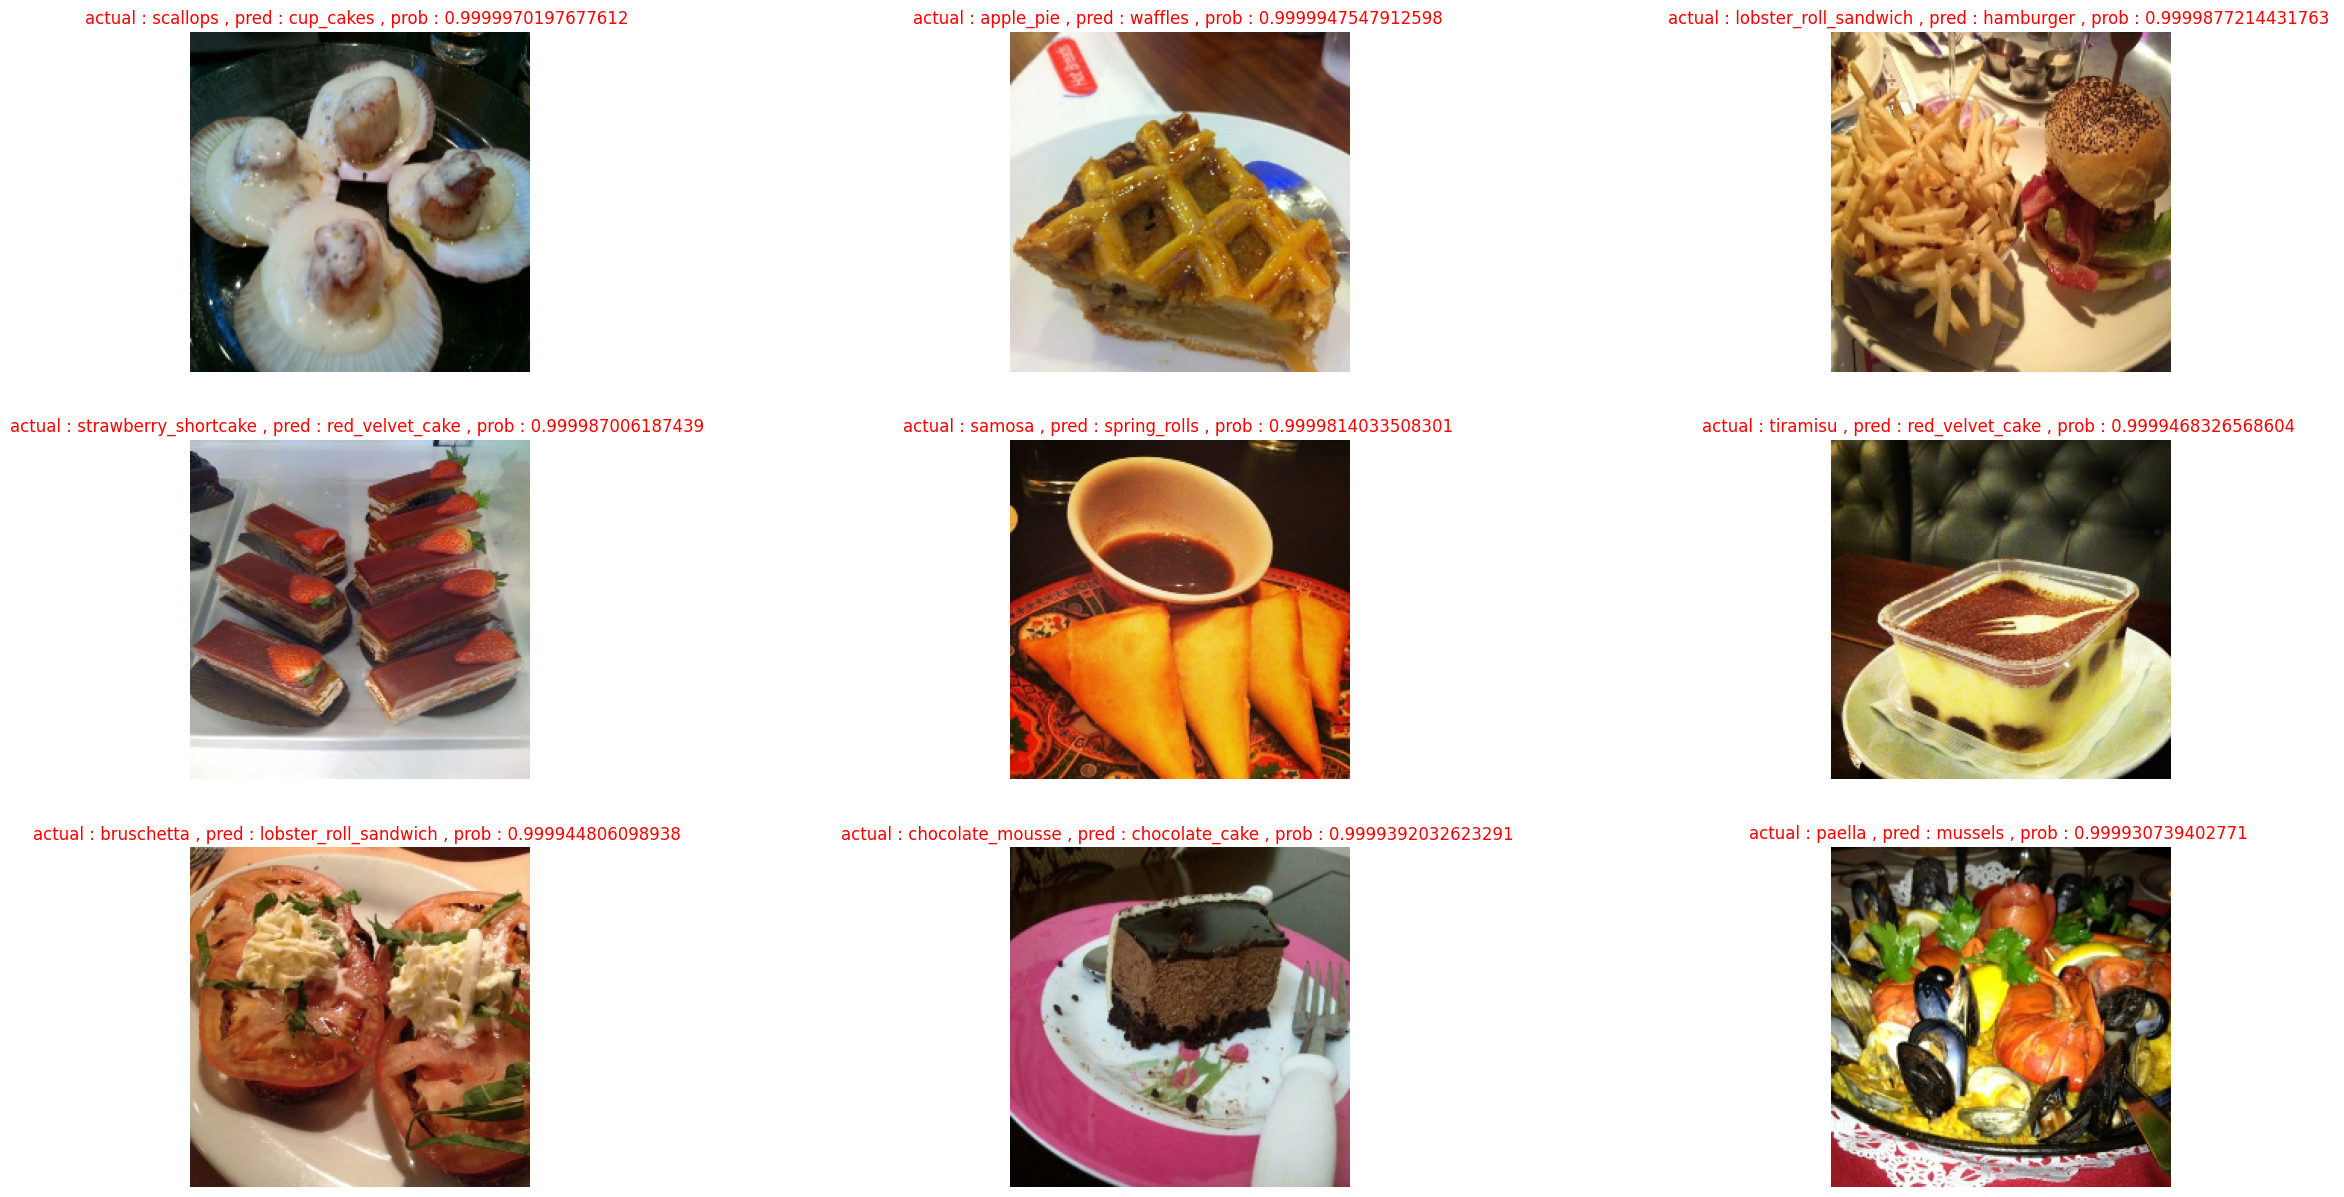

In [71]:
# Visualize the test data samples which have the wrong prediction but highest probability

images_to_view = 9
start_index = 0   # Bunları atamamızın sebebi top 100 wrong dataframindeki ilk rowa bakarsak 21810 oldugunu görüyoruz biz düzgün order yapıyoruz bu şekilde
plt.figure(figsize = (30 , 15))

for i , row in enumerate(top_100_wrong[ start_index : start_index + images_to_view ].itertuples()):  # itertuples ile rowun içindeki değerleri alıp tuple a dönüştürüyor.
  print(row)
  plt.subplot( 3 , 3 , i+1)
  img = load_and_prep_image(row[1] , scale = False)  # Tuple ın içinde de indexleme 0 dan başlıyor. image_path ın indexi 1 oldugu icin row[1] yapıyoruz.
  plt.imshow(img/255.)
  if row[5] == row[6]:  # if predicted class matches truth class , the text will be green , if not , the text will be red
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual : {row[5]} , pred : {row[6]} , prob : {row[4]} " , c = title_color)
  plt.axis(False);

In [72]:
# Get custom images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-08-13 18:16:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 172.253.117.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  43.5MB/s    in 0.3s    

2023-08-13 18:16:09 (43.5 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [78]:
# Get custom food images path
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images") ]

custom_food_images


['custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 50ms/step


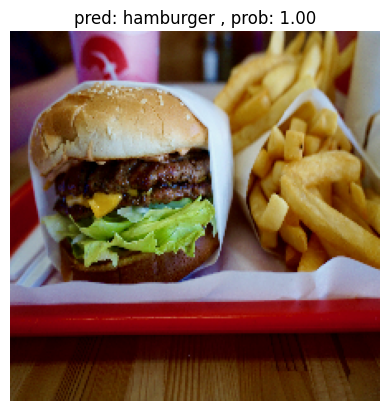

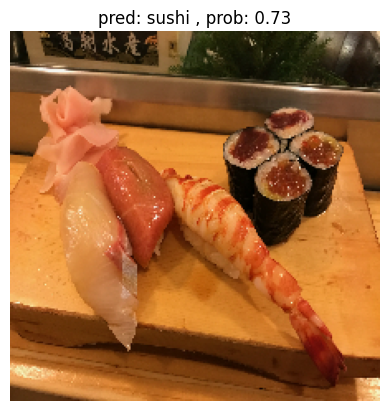

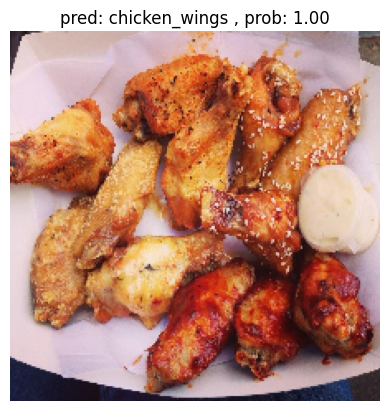

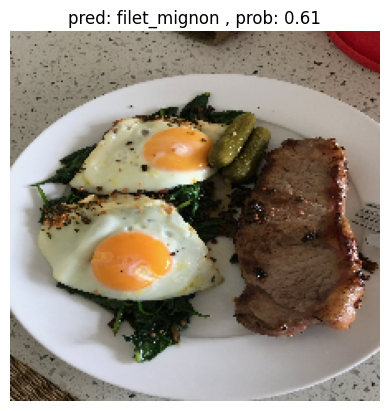

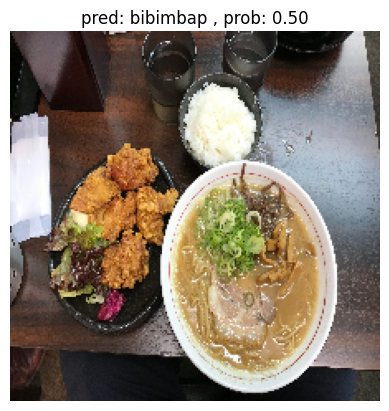

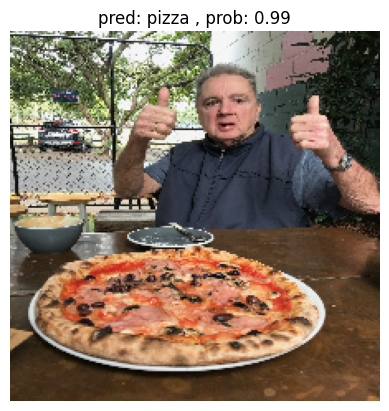

In [96]:
# Make predictions on and plot custom images

for img in custom_food_images:
  img = load_and_prep_image(img , scale = False)
  pred_prob = model_pre.predict(tf.expand_dims(img , axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class} , prob: {pred_prob.max():.2f}")
  plt.axis(False)
